In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate, constants, signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
import platform
import datetime
import shapely
import utm

In [2]:
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
fig_folder='D:\\OneDrive - NERC\\OneDrive - NERC\\SEASTAR\\PM WP4000\\figures\\'

In [4]:
#version = 'v20230119'
version = 'v20221208_2'
#version = 'FINAL'
#flight = '20220517'
file_paths = ss.utils.readers._set_file_paths()
oscar_path = os.path.join(file_paths['oscar_path'], version, 'matlab-pre-processed','')
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

#DAR_tracks={
#    'Track_2' : 1,
#    }
DAR_tracks={
    'Track_1' : 0,
#    'Track_2' : 1,
    }
#
# L1a variables to be passed to L1b dataset
vars_to_keep = [
        'LatImage',
        'LonImage',
        'IncidenceAngleImage',
        'LookDirection',
        'SquintImage',
        'CentralFreq',
        ]
# Compute L1C - Sigma0 + RVL
ds_L1b = dict()
for track in DAR_tracks.keys():
#for track in ['Track_15']:
    ds_ml = dict()
    file_index = DAR_tracks[track]
    ds_L1a = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index,'...')
    
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_ml[dict_index])
        
        ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
        ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
#-----------------------------------------------------------
    ds_ml = fill_missing_variables(ds_ml, antenna_ident)

# Build L1b dataset

    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml
    
print('...Done')

Device name = LIVPCZG-10
Setting local paths...
OSCAR L1 processing - version v20221208_2
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\v20221208_2\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
Processing file index 0 ...
...Done


In [75]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')

AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()),
                        dim='time',
                       join='outer')
del AROME_dict
ds_L2 = dict()
for track in ds_L1b.keys():
    
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1b[track], wind_speed.data, wind_direction.data)
    # Compute RSC
    #ds_L1b[track] = ss.oscar.level1.compute_radial_surface_current(ds_L1b[track], aux, gmf='mouche12')
    ds_L1b[track]  = compute_radial_surface_current(ds_L1b[track] , aux, gmf='mouche12')
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1b[track])
    # Compute current magnitude and direction
    ds_L2[track] = seastar.retrieval.level2.compute_current_magnitude_and_direction(ds_L1b[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentMagnitude'], ds_L2[track]['CurrentDirection'])
    


In [79]:
ds_L2['Track_1']

<xarray.Dataset>
Dimensions:                  (GroundRange: 413, CrossRange: 2477)
Coordinates:
  * GroundRange              (GroundRange) float32 528.0 536.0 ... 3.824e+03
  * CrossRange               (CrossRange) float32 -1.101e+04 ... 8.8e+03
    latitude                 (CrossRange, GroundRange) float64 48.34 ... 48.52
    longitude                (CrossRange, GroundRange) float64 -5.103 ... -5.156
Data variables:
    CurrentMagnitude         (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentDirection         (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorUComponent  (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorVComponent  (CrossRange, GroundRange) float64 nan nan ... nan

In [77]:
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(file_paths['xband_file'], ds_L2[track])
ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
    compute_Xband_current_magnitude_and_direction(ds_xband)

folder='unrestricted'
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'
list22['HF_radial'] = 'HF_Brezellec_Radial_2022.nc'
list22['HF_0522'] = 'HF_combined_20220522.nc'

os.path.join(file_paths['aux_path'], folder, list22['L1'])
#F1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['F1'])
#L1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['L1'])
#W3 = xr.open_dataset(file_paths['aux_path'] + folder + list22['W3'])
L1 = xr.open_dataset(os.path.join(file_paths['aux_path'], folder, list22['L1']))

cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
L1['CurrentMagnitude'] = (('time','nj','ni'), cvel)
L1['CurrentDirection'] = (('time','nj','ni'), cdir)
timesel = np.argmin(np.abs(L1.time.data - ds_L1b[track].sel(Antenna='Mid').TrackTime.data))
L1_CurrentMagnitude_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentMagnitude.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track]
                                                                                )
L1_CurrentDirection_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentDirection.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track]
                                                                                )


ValueError: conflicting sizes for dimension 'GroundRange': length 2477 on the data but length 413 on coordinate 'GroundRange'

In [ ]:
fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(1,1,1)

ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
plt.plot(ds_xband.longitude_RADAR,ds_xband.latitude_RADAR, marker="^", color='r', markersize=20)
#ds_xband.plot.scatter(x='longitude_RADAR', y='latitude_RADAR',s=1000)
#ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
gl=ax.gridlines(draw_labels=True)

In [ ]:
track='Track_1'
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=ds_xband\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ds_xband\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',y='latitude',
    u='Ux',v='Uy',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
#ds_xband.plot.scatter(x='longitude_RADAR', y='latitude_RADAR')
plt.title('X-band derived surface currents \n 2022-05-17 \n Colocated on OSCAR grid')
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
#ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
ax.set_extent([-5.2, -5.025, 48.37, 48.5])
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=20)
#plt.show()

#SMALL_SIZE = 20
#MEDIUM_SIZE = 10
#BIGGER_SIZE = 12
#
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.savefig(fig_folder + 'Xband_20220517_new.png', dpi=150, bbox_inches='tight')
#ax.set_xlabel('Latitude', fontsize=14)

In [ ]:
trim_factor = 1
fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=ds_xband\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

plt.xlim([200,360])
plt.ylim([200,360])
plt.plot([200,360],[200,360],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('X-band surface current direction (deg)',fontsize=20)
plt.ylabel('OSCAR surface current direction (deg)',fontsize=20)
plt.title('OSCAR / Xband \n'
          + 'Current Direction comparison '
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )

#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_Xband_direction_comparison_new.png', dpi=150, bbox_inches='tight')

fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=ds_xband\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentMagnitude.values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentMagnitude.values.flatten(),
    gridsize=100,
    cmap='gist_yarg',
)

vmin=0
vmax=2

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')
#plt.axis('equal')
#plt.title('Derived surface currents')
plt.xlabel('X-band surface current velocity (m/s)',fontsize=20)
plt.ylabel('OSCAR retrieved surface current velocity (m/s)',fontsize=20)
plt.title('OSCAR / Xband \n'
          + 'Current Magnitude comparison '
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_Xband_magnitude_comparison_new.png', dpi=150, bbox_inches='tight')

In [ ]:
#np.sqrt(np.nanmean(ds_xband.CurrentMagnitude.values.flatten() - ds_L2[track].CurrentMagnitude.values.flatten()) **2 )
np.sqrt(np.nanmean(ds_xband.CurrentDirection.values.flatten() - ds_L2[track].CurrentDirection.values.flatten()) **2 )

NameError: name 'fig_folder' is not defined

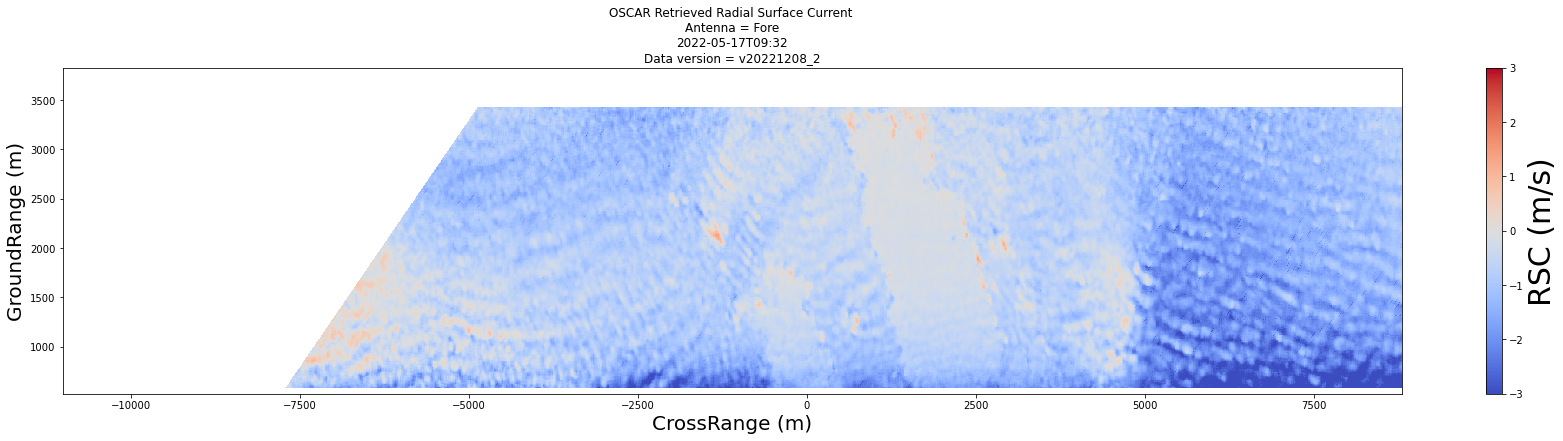

In [80]:
for beam in ['Fore','Aft']:
    im = ds_L1b[track]\
    .sel(Antenna=beam)\
    .RadialSurfaceCurrent\
    .plot(figsize=(30, 6),
          y='GroundRange',
          x='CrossRange',
          robust=True,
          cmap='coolwarm',
          add_colorbar=False,
          vmin=-3,vmax=3
         )
    cbar = plt.colorbar(im)
    cbar.set_label('RSC (m/s)',fontsize=30)
    plt.xlabel('CrossRange (m)',fontsize=20)
    plt.ylabel('GroundRange (m)',fontsize=20)
    plt.title('OSCAR Retrieved Radial Surface Current \n'
              + 'Antenna = '
              + beam
              +'\n'
              + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
              +'\n'
              + 'Data version = ' + version
             )
    plt.savefig(fig_folder + 'RSC_' + beam + '.png', dpi=150, bbox_inches='tight')

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

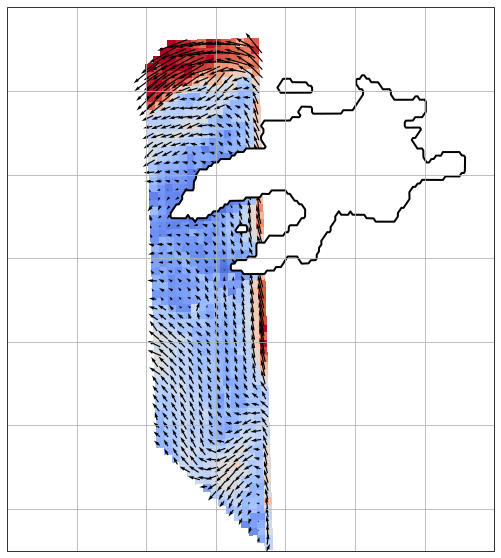

In [81]:
track='Track_1'
tracktime = str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor_image = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=ds_L2[track]\
.coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
.coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ds_L2[track]\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=50,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)

#plt.title(ds_L1b[track].attrs['Title'])
gl=ax.gridlines(draw_labels=False)
gl.top_labels=False
gl.right_labels=False

gl.bottom_labels=False
gl.left_labels=False

ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

#cbar = plt.colorbar(im)
#cbar.set_label('RSC velocity (m/s)',fontsize=30)

#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.title('OSCAR Retrieved surface current velocity \n'
#              + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
#              +'\n'
#              + 'Data version = ' + version
#             )
#
#plt.savefig(fig_folder + 'OSCAR_RSC_20220517_new_transparent.png', dpi=150, bbox_inches='tight', transparent=True)
#plt.savefig(fig_folder + 'RSC_magnitude.png', dpi=150)
#ax.set_xlabel('Latitude', fontsize=14)

In [ ]:
L1.time.isel(time=timesel).data

In [ ]:


track='Track_1'
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
L1.CurrentMagnitude\
.isel(time=timesel)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
L1\
.isel(time=timesel)\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_coloc',
    v='V_coloc',
    scale=30,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)

plt.title('MARS2D')
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top=False
gl.ylabels_right=False
ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.title('MARS2D Current velocity \n'
              + 'Model = ' + str(np.datetime64(L1.time.isel(time=timesel).data,'m')) +'\n'
             )

plt.savefig(fig_folder + 'MARS2D_20220517.png', dpi=150, bbox_inches='tight')

In [ ]:
trim_factor = 1
fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=L1_CurrentMagnitude_colocated\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentMagnitude.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

vmin=0
vmax=2

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')

#plt.axis('equal')
plt.title('Surface currents comparison \n'
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )
plt.xlabel('MARS2D surface current magnitude (m/s)',fontsize=20)
plt.ylabel('OSCAR surface current magnitude (m/s)',fontsize=20)
#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_MARS2D_magnitude_comparison.png', dpi=150, bbox_inches='tight')

fig = plt.figure(figsize=(10, 10))
plt.hexbin(
    x=L1_CurrentDirection_colocated\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .values.flatten(), 
    y=ds_L2[track]\
    .coarsen(GroundRange=trim_factor,boundary='trim').mean()\
    .coarsen(CrossRange=trim_factor,boundary='trim').mean()\
    .CurrentDirection.values.flatten(),
    gridsize=200,
    cmap='gist_yarg',
)

vmin=200
vmax=360

plt.xlim([vmin,vmax])
plt.ylim([vmin,vmax])
plt.plot([vmin,vmax],[vmin,vmax],'k')
#plt.axis('equal')
plt.title('Surface currents comparison \n'
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
          +'\n'
          + 'Data version = ' + version
         )
plt.xlabel('MARS2D surface current direction (deg)',fontsize=20)
plt.ylabel('OSCAR surface current direction (deg)',fontsize=20)
#ax.set(xticklabels=[])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.savefig(fig_folder + 'OSCAR_MARS2D_direction_comparison_new.png', dpi=150, bbox_inches='tight')


In [ ]:
np.sqrt(np.nanmean(ds_xband.CurrentMagnitude.values.flatten() - ds_L2[track].CurrentMagnitude.values.flatten()) **2 )
#np.sqrt(np.nanmean(L1_CurrentDirection_colocated.values.flatten() - ds_L2[track].CurrentDirection.values.flatten()) **2 )

In [ ]:
track='Track_1'
# Plot current magnitude with u,v vectors overlain, geographic coordinates
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)
#c_factor = 1 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=(ds_L2[track].CurrentMagnitude-L1_CurrentMagnitude_colocated)\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=-3, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
#L1\
#.isel(time=timesel)\
#.plot.quiver(
#    x='longitude',
#    y='latitude',
#    u='U_coloc',
#    v='V_coloc',
#    scale=30,
#    angles='xy',
#    robust=True,
#    transform=ccrs.PlateCarree()
#)

plt.title('Difference between OSCAR and MARS2D \n' 
          + str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m')))

gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=Warning)
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)

cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Current velocity (m/s)',fontsize=30)
#plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
#plt.show()

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.title('Difference between OSCAR RSC and MARS2D currents \n'
              + 'Track = ' + tracktime + '\n'
              + 'Model = ' + str(np.datetime64(L1.time.isel(time=timesel).data,'m')) +'\n'
              + 'Data version = ' + version
             )

plt.savefig(fig_folder + 'OSCAR_MARS2D_difference_20220517_new.png', dpi=150, bbox_inches='tight')


In [29]:
def find_coordinate_origin(ds, coord):
    coord_origin = ds[coord][np.where(ds[coord] == np.min(np.abs(ds[coord])))]
    coord_origin = coord_origin.data
    return coord_origin


In [28]:
def track_title_to_datetime(title):

    year = title.split()[2].split('T')[0][0:4]
    month = title.split()[2].split('T')[0][4:6]
    day = title.split()[2].split('T')[0][6:8]
    hour = title.split()[2].split('T')[1][0:2]
    minute = title.split()[2].split('T')[1][2:4]
    second = title.split()[2].split('T')[1][4:6]
    track_time = np.datetime64(year + '-' + month + '-' + day + 'T' + hour + ':' + minute + ':' + second)
    return track_time

In [7]:
def merge_beams(ds_dict, antenna_id):

    ds_level1 = xr.concat(objs=list(ds_dict.values()),
                          dim='Antenna',
                          join='outer',
                          coords='all',
                         )
    
    ds_level1 = ds_level1.assign_coords(Antenna=('Antenna', antenna_id))
    key_list = list(ds_dict.keys())
    ds_level1.coords['latitude'] = xr.merge(
            [ds_dict[key_list[0]].LatImage.dropna(dim='CrossRange'),
             ds_dict[key_list[1]].LatImage.dropna(dim='CrossRange'),
             ds_dict[key_list[2]].LatImage.dropna(dim='CrossRange')],
            #compat='override',
            ).LatImage
    ds_level1.coords['longitude'] = xr.merge(
            [ds_dict[key_list[0]].LonImage.dropna(dim='CrossRange'),
             ds_dict[key_list[1]].LonImage.dropna(dim='CrossRange'),
             ds_dict[key_list[2]].LonImage.dropna(dim='CrossRange')],
            #compat='override',
            ).LonImage

    return ds_level1

In [27]:
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    """
    Compute radial surface current (RSC).

    Compute radial surface current (RSC) from radial surface velocity (RSV)
    and the wind artifact surface velocity (WASV) from:
        RSC = RSV - WASV

    Parameters
    ----------
    level1 : xarray.Dataset
        L1 dataset
    aux : xarray.Dataset
        Dataset containing geophysical wind data
    gmf : str, optional
        Choice of geophysical model function to compute the WASV.
        The default is 'mouche12'.

    Returns
    -------
    level2 : xarray.Dataset
        L2 dataset

    """
    dswasv = seastar.gmfs.doppler.compute_wasv(level1,
                                               aux,
                                               gmf
                                               )
    rsv_list = [level1.RadialSurfaceVelocity.sel(Antenna=a)
                - dswasv.sel(Antenna=a)
                for a in list(level1.Antenna.data)
                ]
    rsv_list[list(level1.Antenna.data).index('Aft')] = \
    -level1.RadialSurfaceVelocity.sel(Antenna='Aft') - dswasv.sel(Antenna='Aft')
    level1['RadialSurfaceCurrent'] = xr.concat(rsv_list,
                                               'Antenna',
                                               join='outer')
    level1['RadialSurfaceCurrent'] = level1.RadialSurfaceCurrent\
        .assign_coords(Antenna=('Antenna',
                                list(level1.Antenna.data)
                                )
                       )
    level1.RadialSurfaceCurrent.attrs['long_name'] =\
        'Radial Surface Current (RSC) along antenna beam direction, corrected'\
        'for Wind Artifact Surface Velocity (WASV)'
    level1.RadialSurfaceCurrent.attrs['units'] = '[m/s]'

    return level1

In [26]:
def shift_coordinate_origin(ds_dict, coord):

    origins=np.full((len(ds_dict),1),0.0)
    
    for beam in ds_dict.keys():
        origins[list(ds_dict.keys()).index(beam)] = ds_dict[beam][coord].sel(CrossRange=0).isel(GroundRange=0).data
    
    origins_diff = np.diff(origins, axis=0)
    origins_diff = np.insert(origins_diff, 0, 0)
    for beam in ds_dict.keys():
        ds_dict[beam][coord] = ds_dict[beam][coord] - origins_diff[list(ds_dict.keys()).index(beam)]
    return ds_dict

In [3]:
def fill_missing_variables(ds_dict, antenna_id):

    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    # Find vars that dont exist in Mid , but exist in Fore
    for var in ds_dict[fore_id].data_vars:
        if var not in ds_dict[mid_id].data_vars:
            var_shape = (
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[0]]),
                len(ds_dict[mid_id][list(ds_dict[mid_id].dims)[1]]))
            ds_dict[mid_id][var] = xr.DataArray(
                data=np.full(var_shape, np.NaN),
                coords=ds_dict[mid_id].coords,
                dims=ds_dict[mid_id].dims)
    # Find vars that dont exist in Fore for Aft , but exist in Mid
    for var in ds_dict[mid_id].data_vars:
        for antenna in [fore_id, aft_id]:
            if var not in ds_dict[antenna].data_vars:
                ds_dict[antenna][var] = xr.DataArray(
                    data=np.full(ds_dict[mid_id][var].shape, np.NaN),
                    coords=ds_dict[mid_id][var].coords,
                    dims=ds_dict[mid_id][var].dims)

    return ds_dict

In [10]:
def compute_land_mask_from_GSHHS(ds, erosion=False, boundary=None,
                                 erode_scale=3, coastline_selection=0):

    if 'longitude' not in ds.coords or 'latitude' not in ds.coords:
        raise Exception('longitude and latitude missing from input dataset')
    if not boundary:
        boundary = [np.min(ds.longitude.data),
                    np.max(ds.longitude.data),
                    np.min(ds.latitude.data),
                    np.max(ds.latitude.data)]

    if erosion:
        erode_scale = int(np.round(erode_scale))
        erode_structure = np.full((erode_scale, erode_scale), True)
    coast_polygons = dict()
    print('Scanning GSHHS dataset for coastlines within boundary...')
    coast = cfeature.GSHHSFeature(scale='full')\
        .intersecting_geometries(boundary)

    for k, polygon in enumerate(coast):
        coast_polygons[k] = polygon
    if type(coastline_selection) is int:
        coastline_selection = [coastline_selection]
    if np.max(coastline_selection) > k:
        raise Exception('Selected coastline(s)',
                        coastline_selection,
                        ' different to coastlines identified within boundary ',
                        list(coast_polygons.keys()),
                        '. Please try a different coastline_selection (default=0)'
                        )

    coast_polygons = {key: coast_polygons[key]
                      for key in coastline_selection}
    m, n = ds.longitude.shape
    mask = np.full((m, n), False)
    count = 0
    print('Performing search...')
    for i in range(m):
        for j in range(n):
            count = count + 1
            if not int(np.mod(count, ((m * n) / 10))):
                print(int((count / (m*n)) * 100),'% complete')

            for k in coast_polygons.keys():
                mask[i, j] = mask[i, j] or\
                    Point(ds.longitude.data[i, j], ds.latitude.data[i, j])\
                    .within(coast_polygons[k])
    print('...done')
    if erosion:
        mask = erode(mask, structure=erode_structure)
    mask = xr.DataArray(data=mask,
                        coords=ds.latitude.coords,
                        dims=ds.latitude.dims)

    return mask, coast_polygons

In [11]:
t = time.time()
mask, coast_polygons = compute_land_mask_from_GSHHS(ds_L1b['Track_1'])
time.time() - t

Scanning GSHHS dataset for coastlines within boundary...
Performing search...
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
...done


157.81285858154297

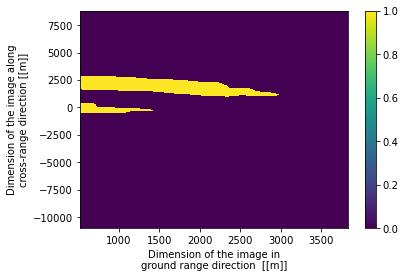

In [128]:
mask[0].plot()

In [64]:
coastline_selection=0
boundary = [np.min(ds_L1b['Track_1'].longitude.data),
            np.max(ds_L1b['Track_1'].longitude.data),
            np.min(ds_L1b['Track_1'].latitude.data),
            np.max(ds_L1b['Track_1'].latitude.data)]
coast_polygons = dict()
coast = cfeature.GSHHSFeature(scale='full')\
        .intersecting_geometries(boundary)
for k, polygon in enumerate(coast):
        coast_polygons[k] = polygon
if type(coastline_selection) is int:
        coastline_selection = [coastline_selection]
coast_polygons = {key: coast_polygons[key]
                      for key in coastline_selection}
m, n = ds_L1b['Track_1'].longitude.shape
mask = np.full((m, n), False)




In [66]:
coast_polygons[0].bounds

(-5.141306, 48.436222, -5.035444, 48.48375)

In [123]:
mask = np.full((m, n), False)
t = time.time()
mask[i, j] = mask[i, j] or\
Point(ds_L1b['Track_1'].longitude.data[i, j], ds_L1b['Track_1'].latitude.data[i, j])
p = time.time() - t
(m*n) * p

0.0

In [141]:
count=1
round(np.mod(count, (m * n) / percent_complete))


1

In [31]:
for i in range(100):
    if not np.mod(i, (10*10) / 10):
        print((i/100) * 100)

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


In [146]:
count = 0
percent_complete = 10

for i in range(m):
        for j in range(n):
            count = count + 1
            if not int(np.mod(count, (m * n) / percent_complete)):
                print('Performing search,', int((count / (m*n)) * 100),'% complete')

Performing search, 10 % complete
Performing search, 20 % complete
Performing search, 30 % complete
Performing search, 40 % complete
Performing search, 50 % complete
Performing search, 60 % complete
Performing search, 70 % complete
Performing search, 80 % complete
Performing search, 90 % complete


In [9]:
import time
from shapely.geometry import Point